In [1]:
import numpy as np
from numpy.random import RandomState, SeedSequence
from numpy.random import MT19937
from keras.optimizers import adam_v2
from PIL import Image
from pathlib import Path
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.regularizers import l2
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
from art.defences.postprocessor import ReverseSigmoid

In [3]:
from art.attacks.extraction import CopycatCNN
from art.attacks.extraction import KnockoffNets
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_cifar10

In [4]:
import tensorflow as tf

## Ataque de extracción

### Imagen de entrenamientos

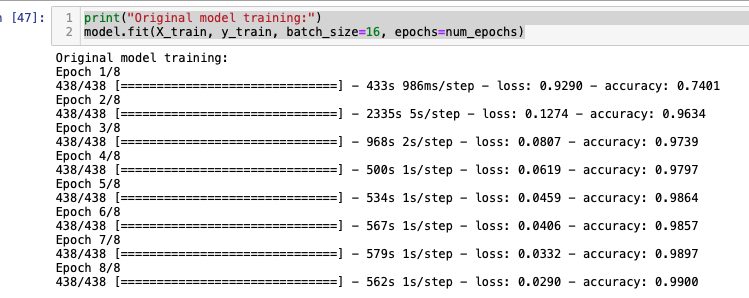

### Imagen de resultados

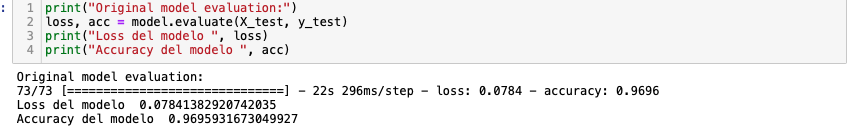

## Cargar data no conocida

Se utilizara la data que no se utilizo para entrenar el modelo en el laboratorio #7.
La razón por que se opto por este approach en lugar de utilizar data aleatoría es porque para la data aleatoría necesitariamos tener estratificado los resultados de los labels que los scamos realizando predicciones sobre el modelo general pero el modelo con data aleatoria tiende a retornar el label 12 (index 12) que corresponde a 'Allaple.A' que tiene un total de  2949  ejemplares.

In [5]:
images_resized = np.load('images_resized_clean.npy')

In [6]:
labels_np_real = np.load('labels_np_clean.npy')

In [100]:
labels_np_real.shape

(2335, 25)

#### Aleateorizamos la data

In [101]:
indices = np.random.permutation(len(images_resized))

In [119]:
size = 1000
stolen_images = images_resized[indices[:size]]
stolen_labels = labels_np_real[indices[:size]]
stolen_images_test = images_resized[indices[size:]]
stolen_labels_test = labels_np_real[indices[size:]]

## Creación del modelo

Se define una función para poder crear el modelo 

In [7]:
def get_model(num_classes=25, c1=32, c2=64, d1=128, shape=(200,200, 3)):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten(input_shape=shape))
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

### Cargada de modelo
Se carga el modelo inicial y se pone un mayor limite de recursión para permitir cargar el modelo

In [9]:
import sys
sys.setrecursionlimit(1500)
model_to_be_attacked_keras = tf.keras.models.load_model('model_v2')
tf.compat.v1.disable_eager_execution()
victim_keras = KerasClassifier(model_to_be_attacked_keras, clip_values=(0, 1), use_logits=False)

#### Generación de imagenes aleatorias
Se muestra el código que se tulizo para porbar con data aleatoría

In [8]:
# random_non_existen_data = np.random.randint(0, 255, (25, 200, 200, 200, 3)) 

In [9]:
# random_non_existen_data_b = np.random.randint(0, 255, (250, 200,200, 3)) 

In [16]:
# for index, data_files in enumerate(random_non_existen_data):
#     for index2, data in enumerate(data_files):
#         img = Image.fromarray(data.astype('uint8')).convert('RGBA')
#         Path('./random_images/' + str(index)).mkdir(parents=True, exist_ok=True)
#         img.save('./random_images/' + str(index) + '/image_' + str(index2) + '.png')

In [13]:
# print(random_non_existen_data.shape)

(5000, 25)
(25, 200, 200, 200, 3)


In [14]:
# new_arr_data = random_non_existen_data.reshape(5000,200,200,3)

In [ ]:
# new_arr_data = new_arr_data/255.0

### Predicciones con la data inventada

A continucación mostramos como se habían generado los labels para las imagenes aleatorias.

In [55]:
# labels= model_to_be_attacked_keras.predict(x=new_arr_data)
# labels[0]

array([5.71114803e-03, 2.31319253e-04, 1.79514813e-04, 2.80998188e-06,
       4.72541046e-08, 1.88921076e-05, 3.57321042e-05, 2.38871803e-06,
       2.06419190e-06, 1.39200540e-06, 2.69562732e-02, 1.19460812e-02,
       7.06626594e-01, 1.32941722e-07, 3.98512867e-07, 2.41733119e-01,
       2.91413278e-03, 6.62659403e-08, 1.27168823e-05, 2.81349094e-05,
       2.29568250e-05, 9.71693837e-09, 3.26256314e-03, 1.02580554e-04,
       2.08893034e-04], dtype=float32)

In [60]:
# labels_norm = []
# for label in labels:
#     values = np.zeros(25)
#     values[np.argmax(label)] = 1
#     labels_norm.append(values)

# labels_norm = np.array(labels_norm)
# labels_norm.shape

(5000, 25)

# Ataques de Extracción (Modelo no protegido)

## CopyCatCNN Argmax

### Creación del modelo y calsificador ladron

In [103]:
thieved_tfc = KerasClassifier(
    get_model(num_classes=25, c1=32, c2=64, d1=128, shape=stolen_images[0].shape), clip_values=(0, 1), use_logits=False
)

In [125]:
copycat_cnn = CopycatCNN(
    classifier=victim_keras,
    batch_size_fit=64,
    batch_size_query=64,
    nb_epochs=8,
    nb_stolen=1000,
    use_probability=False
)

In [126]:
# training_random
thieved_krc = copycat_cnn.extract(x=stolen_images, y=stolen_labels, thieved_classifier=thieved_tfc)

Train on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 44s 44ms/sample - loss: 0.1044 - accuracy: 0.9870
Epoch 2/8
1000/1000 [==============================] - 46s 46ms/sample - loss: 0.0846 - accuracy: 0.9870
Epoch 3/8
1000/1000 [==============================] - 75s 75ms/sample - loss: 0.3500 - accuracy: 0.9350
Epoch 4/8
1000/1000 [==============================] - 60s 60ms/sample - loss: 0.0654 - accuracy: 0.9950
Epoch 5/8
1000/1000 [==============================] - 67s 67ms/sample - loss: 0.0493 - accuracy: 0.9960
Epoch 6/8
1000/1000 [==============================] - 60s 60ms/sample - loss: 0.0379 - accuracy: 1.0000
Epoch 7/8
1000/1000 [==============================] - 60s 60ms/sample - loss: 0.0304 - accuracy: 1.0000
Epoch 8/8
1000/1000 [==============================] - 66s 66ms/sample - loss: 0.0268 - accuracy: 1.0000


### Resultados CopyCatCNN

In [127]:
victim_preds = np.argmax(model_to_be_attacked_keras.predict(x=stolen_images_test), axis=1)

In [128]:
thieved_preds = np.argmax(thieved_krc.predict(x=stolen_images_test), axis=1)

<b>Accuracy con respecto a las mismas predicciones con otro set al modelo original<b/>

In [129]:
acc = np.sum(victim_preds == thieved_preds) / len(victim_preds)
acc

0.9625468164794008

<b>Accuracy del modelo vs los labels correctos</b>

In [130]:
thieved_krc._model.evaluate(stolen_images_test, stolen_labels_test)
# stolen_labels_test.shape

[0.49483866660894077, 0.94756556]

Con el copycat miramos que hubieron buenos resultados tuvo un accuracy del 96% con las predicciones del modelo
y en su evaluación con el set de testeo tuvo un 94% de accuracy.

In [136]:
thieved_krc._model.save('./model_copycatt_cnn')

2022-05-25 15:44:05.450497: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model_copycatt_cnn/assets


## KnockoffNets Argmax
Se observara que pasa al agregarle al modelo también el ataque de knock off nets

In [149]:
thieved_tfc_2 = KerasClassifier(
    get_model(num_classes=25, c1=32, c2=64, d1=128, shape=stolen_images[0].shape), clip_values=(0, 1), use_logits=False
)

In [150]:
knockoff_nets = KnockoffNets(
    classifier=victim_keras,
    batch_size_fit=64,
    batch_size_query=64,
    nb_epochs=8,
    nb_stolen=1000,
    use_probability=False,
    verbose=True
)

In [151]:
thieved_krc_with_knock_off = knockoff_nets.extract(x=stolen_images, y=stolen_labels, thieved_classifier=thieved_tfc_2)

### Resultados KnockoffNets Argmax

In [152]:
thieved_preds_knock_off = np.argmax(thieved_krc_with_knock_off.predict(x=stolen_images_test), axis=1)

/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<b>Accuracy con respecto a las mismas predicciones con otro set al modelo original<b/>

In [158]:
acc = np.sum(victim_preds == thieved_preds_knock_off) / len(victim_preds)
print("Accuracy de las predicciones del modelo original vs el modelo a partir del atque: ", acc*100)

Accuracy de las predicciones del modelo original vs el modelo a partir del atque:  88.46441947565543


<b>Accuracy del modelo vs los labels correctos</b>

In [155]:
loss_k, acc_k = thieved_krc_with_knock_off._model.evaluate(stolen_images_test, stolen_labels_test)

In [157]:
print("Accuracy vs los labels correctos: ", acc_k*100)

Accuracy vs los labels correctos:  87.04119920730591


In [160]:
thieved_krc_with_knock_off._model.save('./model_knock_off')

INFO:tensorflow:Assets written to: ./model_knock_off/assets


## Resultados ataques de extracción del modelo no protegido

Se observo mejores resultados con el modelo de copycatcnn teniendo un 96% de accuracy con el modelo original tommando un tiempo de entrenamiento de 8 minutos 1 por cada epoch prácticamente. A pesar que no es igual de bueno notamos que tiene un excelente resultado para los recursos gastados para entrenar el modelo vs el original que se gastaron alrededor de 99 minutos.

Respecto a los resultados de KnockoffNets notamos que no fueron tan buenos como lso de copycatt sin embargo si fueron buenos y con un menor tiempo notamos que respecto al modelo original tiene un 88% de accuracy en sus predicciones y en general vs los true labels tiene un 87% de accuracy

## Crear modelo protegido

In [16]:
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model_to_be_attacked_keras, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)


# Ataques de Extracción (Modelo protegido)

## CopyCatCNN Argmax

In [163]:
copycat_cnn_protected = CopycatCNN(
    classifier=classifier_protected,
    batch_size_fit=64,
    batch_size_query=64,
    nb_epochs=8,
    nb_stolen=1000,
    use_probability=False
)

In [165]:
copycat_cnn_protected_classifier = copycat_cnn_protected.extract(x=stolen_images, y=stolen_labels, thieved_classifier=KerasClassifier(
    get_model(num_classes=25, c1=32, c2=64, d1=128, shape=stolen_images[0].shape), clip_values=(0, 1), use_logits=False
))

Train on 1000 samples
Epoch 1/8
1000/1000 [==============================] - 52s 52ms/sample - loss: 3.1667 - accuracy: 0.2060
Epoch 2/8
1000/1000 [==============================] - 49s 49ms/sample - loss: 2.2479 - accuracy: 0.3440
Epoch 3/8
1000/1000 [==============================] - 81s 81ms/sample - loss: 2.0242 - accuracy: 0.4230
Epoch 4/8
1000/1000 [==============================] - 64s 64ms/sample - loss: 1.9175 - accuracy: 0.4300
Epoch 5/8
1000/1000 [==============================] - 66s 66ms/sample - loss: 1.6756 - accuracy: 0.4870
Epoch 6/8
1000/1000 [==============================] - 77s 77ms/sample - loss: 1.5731 - accuracy: 0.5020
Epoch 7/8
1000/1000 [==============================] - 72s 72ms/sample - loss: 1.3180 - accuracy: 0.6110
Epoch 8/8
1000/1000 [==============================] - 71s 71ms/sample - loss: 1.1948 - accuracy: 0.6820


### Resultados CopyCatCNN

In [166]:
thieved_preds_cnn_proteceted = np.argmax(copycat_cnn_protected_classifier.predict(x=stolen_images_test), axis=1)

/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<b>Accuracy con respecto a las mismas predicciones con otro set al modelo original<b/>

In [167]:
acc = np.sum(victim_preds == thieved_preds_cnn_proteceted) / len(victim_preds)
print("Accuracy de las predicciones del modelo original vs el modelo a partir del atque: ", acc*100)

Accuracy de las predicciones del modelo original vs el modelo a partir del atque:  80.0749063670412


<b>Accuracy del modelo vs los labels correctos</b>

In [168]:
loss_cnn_p, acc_cnn_p = copycat_cnn_protected_classifier._model.evaluate(stolen_images_test, stolen_labels_test)
print("Accuracy vs los labels correctos: ", acc_cnn_p*100)

/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy vs los labels correctos:  78.72658967971802


## KnockoffNets Argmax
Se observara que pasa al agregarle al modelo también el ataque de knock off nets

In [169]:
knockoff_nets_procted = KnockoffNets(
    classifier=classifier_protected,
    batch_size_fit=64,
    batch_size_query=64,
    nb_epochs=8,
    nb_stolen=1000,
    use_probability=False,
    verbose=True
)

In [170]:
thieved_krc_with_knock_off_proteted = knockoff_nets_procted.extract(
    x=stolen_images, 
    y=stolen_labels, 
    thieved_classifier=KerasClassifier(
        get_model(num_classes=25, c1=32, c2=64, d1=128, shape=stolen_images[0].shape), clip_values=(0, 1), use_logits=False
    )
)

### Resultados KnockoffNets Argmax

In [171]:
thieved_preds_knock_off_p = np.argmax(thieved_krc_with_knock_off_proteted.predict(x=stolen_images_test), axis=1)

<b>Accuracy con respecto a las mismas predicciones con otro set al modelo original<b/>

In [172]:
acc = np.sum(victim_preds == thieved_preds_knock_off_p) / len(victim_preds)
print("Accuracy de las predicciones del modelo original vs el modelo a partir del atque: ", acc*100)

Accuracy de las predicciones del modelo original vs el modelo a partir del atque:  79.32584269662921


<b>Accuracy del modelo vs los labels correctos</b>

In [173]:
loss_k, acc_k = thieved_krc_with_knock_off_proteted._model.evaluate(stolen_images_test, stolen_labels_test)
print("Accuracy vs los labels correctos: ", acc_k*100)

Accuracy vs los labels correctos:  77.97752618789673


## Resultados ataques de extracción del modelo protegido

<b>Vs modelo original</b><br>
Notamos que en general ambos modelos generados a partir del ataque empeoraron. en el copycat cnn pasamos de tener un 96% de coincidencia en los aciertos con el modelo original observamos que bajamos a 80%.
Al igual que en Knock off nets argmax notamos que  bajo de 88.46% a 78% respecto al modelo original.

<b>Vs los labels evaluando el modelo en su accracy en predecir en general</b><br>
CopyCatCNN notamos que bajo de un 95% de accuracy a 80%
KnockOffMets notamos que bajo un accuracy del 87% al 78%.
Definitivamente notamos que hubo un menor éxito en los ataques a pesar de tener una cantidad de datos 'robados' bastante alta que fueron 1000. Lo mas seguro es que aún asi puede mejorar el perfomance de estos ataques con una mayor cantidad de datos robados. Pero también se puede mejorar la protección del equipo ya que también en numero de épocas siendo mas alta podría mejorar un poco más el perfomance de estos ataques sobre el modelo protegido.

# Gráficas vs dataset size
Crearemos gráficas vs tamaños de datasets mas pequeños para mostrar gráficamente el comportamiento

In [10]:
num_epochs = 6
llen_steal = 300

### Modelos no protegidos

In [11]:
attack_catalogue = {
    "Argmax CopycatCNN": CopycatCNN(classifier=victim_keras,
              batch_size_fit=64,
              batch_size_query=64,
              nb_epochs=num_epochs,
              nb_stolen=llen_steal,
              use_probability=True
),
"Argmax KnockoffNets": KnockoffNets(classifier=victim_keras,
                          batch_size_fit=64,
                          batch_size_query=64,
                          nb_epochs=num_epochs,
                          nb_stolen=llen_steal,
                          use_probability=False,),
}

In [13]:
results = []
for len_steal in [50, 100, 150, 250, 300]:
    indices = np.random.permutation(len(images_resized))
    x_steal = images_resized[indices[:len_steal]]
    y_steal = labels_np_real[indices[:len_steal]]
    x_test = images_resized[indices[len_steal:]]
    y_test = labels_np_real[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=25, c1=32, c2=64, d1=128, shape=x_steal[0].shape)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 50 samples
Epoch 1/6
50/50 [==============================] - 2s 39ms/sample - loss: 3.2833 - accuracy: 0.0000e+00
Epoch 2/6
50/50 [==============================] - 2s 39ms/sample - loss: 3.3133 - accuracy: 0.2800
Epoch 3/6
50/50 [==============================] - 2s 40ms/sample - loss: 3.5324 - accuracy: 0.1600
Epoch 4/6
50/50 [==============================] - 2s 38ms/sample - loss: 2.7111 - accuracy: 0.2400
Epoch 5/6
50/50 [==============================] - 2s 39ms/sample - loss: 2.4490 - accuracy: 0.1600
Epoch 6/6
50/50 [==============================] - 2s 39ms/sample - loss: 2.3035 - accuracy: 0.2800


/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Argmax CopycatCNN : 0.31816193
Argmax KnockoffNets : 0.31816193
Train on 100 samples
Epoch 1/6
100/100 [==============================] - 4s 45ms/sample - loss: 5.1674 - accuracy: 0.1400
Epoch 2/6
100/100 [==============================] - 5s 45ms/sample - loss: 3.1077 - accuracy: 0.2100
Epoch 3/6
100/100 [==============================] - 5s 46ms/sample - loss: 2.6555 - accuracy: 0.1500
Epoch 4/6
100/100 [==============================] - 5s 45ms/sample - loss: 2.2612 - accuracy: 0.3800
Epoch 5/6
100/100 [==============================] - 5s 45ms/sample - loss: 2.2306 - accuracy: 0.3800
Epoch 6/6
100/100 [==============================] - 4s 44ms/sample - loss: 2.2679 - accuracy: 0.1800
Argmax CopycatCNN : 0.3145414
Argmax KnockoffNets : 0.16196868
Train on 150 samples
Epoch 1/6
150/150 [==============================] - 16s 108ms/sample - loss: 4.2889 - accuracy: 0.1333
Epoch 2/6
150/150 [==============================] - 9s 61ms/sample - loss: 3.1716 - accuracy: 0.1533
Epoch 3/6
150

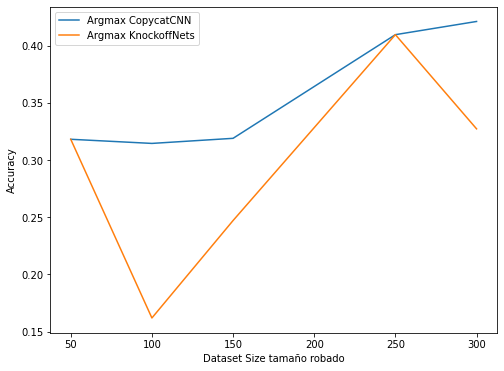

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=('Nombre metodo', 'Dataset Size tamaño robado', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Dataset Size tamaño robado")
ax.set_ylabel("Accuracy")
for name, group in df.groupby("Nombre metodo"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

### Modelos protegidos

In [17]:
attack_catalogue = {
    "Argmax CopycatCNN Protegidos": CopycatCNN(classifier=classifier_protected,
              batch_size_fit=64,
              batch_size_query=64,
              nb_epochs=num_epochs,
              nb_stolen=llen_steal,
              use_probability=True
),
"Argmax KnockoffNets Protegidos": KnockoffNets(classifier=classifier_protected,
                          batch_size_fit=64,
                          batch_size_query=64,
                          nb_epochs=num_epochs,
                          nb_stolen=llen_steal,
                          use_probability=False,),
}

In [18]:
results = []
for len_steal in [50, 100, 150, 250, 300]:
    indices = np.random.permutation(len(images_resized))
    x_steal = images_resized[indices[:len_steal]]
    y_steal = labels_np_real[indices[:len_steal]]
    x_test = images_resized[indices[len_steal:]]
    y_test = labels_np_real[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=25, c1=32, c2=64, d1=128, shape=x_steal[0].shape)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 50 samples
Epoch 1/6
50/50 [==============================] - 2s 39ms/sample - loss: 3.2255 - accuracy: 0.0000e+00
Epoch 2/6
50/50 [==============================] - 2s 41ms/sample - loss: 3.2189 - accuracy: 0.1200
Epoch 3/6
50/50 [==============================] - 2s 41ms/sample - loss: 3.2180 - accuracy: 0.2400
Epoch 4/6
50/50 [==============================] - 2s 42ms/sample - loss: 3.2176 - accuracy: 0.1400
Epoch 5/6
50/50 [==============================] - 2s 42ms/sample - loss: 3.2174 - accuracy: 0.2400
Epoch 6/6
50/50 [==============================] - 2s 40ms/sample - loss: 3.2172 - accuracy: 0.1800


/Users/augustoalonso/security-data-science/Lab7/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Argmax CopycatCNN Protegidos : 0.19781181
Argmax KnockoffNets Protegidos : 0.31641138
Train on 100 samples
Epoch 1/6
100/100 [==============================] - 6s 65ms/sample - loss: 3.2217 - accuracy: 0.1800
Epoch 2/6
100/100 [==============================] - 4s 44ms/sample - loss: 3.2197 - accuracy: 0.1900
Epoch 3/6
100/100 [==============================] - 4s 44ms/sample - loss: 3.2183 - accuracy: 0.3600
Epoch 4/6
100/100 [==============================] - 4s 43ms/sample - loss: 3.2174 - accuracy: 0.3600
Epoch 5/6
100/100 [==============================] - 4s 44ms/sample - loss: 3.2173 - accuracy: 0.3100
Epoch 6/6
100/100 [==============================] - 5s 48ms/sample - loss: 3.2170 - accuracy: 0.3900
Argmax CopycatCNN Protegidos : 0.2541387
Argmax KnockoffNets Protegidos : 0.16196868
Train on 150 samples
Epoch 1/6
150/150 [==============================] - 10s 64ms/sample - loss: 3.2284 - accuracy: 0.2533
Epoch 2/6
150/150 [==============================] - 7s 48ms/sample - lo

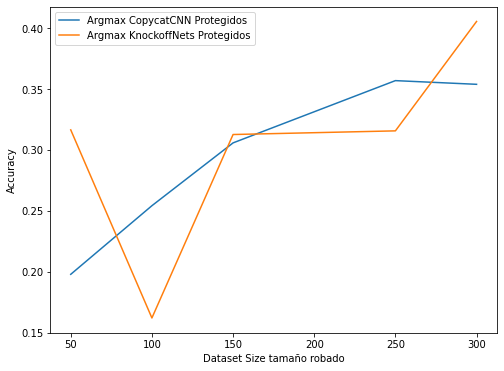

In [19]:
df = pd.DataFrame(results, columns=('Nombre metodo', 'Dataset Size tamaño robado', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Dataset Size tamaño robado")
ax.set_ylabel("Accuracy")
for name, group in df.groupby("Nombre metodo"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

## Resultados en gráficas

Lo que las gráficas nos muestran es que en la mayoría de los datasets se tuvo un menor accuracy en los modelos protegidos vs los no protegidos no es tan evidene como en los resultados de un dataset de 1000 pero nos muestra como se comporta conforme el ds crece si mejora pero mejora de una manera mas lenta.

Tambien en los logs de cada epoch miramos que hay mas loss.

# Conclusiones

- El entrenar el modelo con data inventada para poder realizar un ataque éxitoso  requiere poder tener una muestra representativa a cada clase
- Entre mayo cantidad de datos robados se mejorara el ataque.
- La capa de protección nos permite que el modelo sea menos propenso a ser atacado como demostro el modelo de copycat despues de que fuera protegido que bajo a 77%.
- El ataque de extracción nos puede permitir tener un modelo bastante parecido con muchos menos recursos por lo cual es importante proteger nuestro modelo.